# 19 - Evaluating Causal Models

인과추론에 관한 대부분의 연구에서는 모델을 평가하기 위해 합성 데이터를 사용합니다. Appendix의 **When Prediction Fails** 처럼 모델이 `treatment effect`인 $Y_{1i}-Y_{0i}$를 올바르게 계산하는지 확인하기 위해 $Y_{0i}$, $Y_{1i}$에 대한 모든 데이터를 만들어 냅니다. 연구를 위해서는 괜찮은 방법이지만 실제 업무에 적용하기에는 너무 비싼 방법입니다. 개발한 모델을 업무에 적용하기 전에 왜 현재 모델을 대체해야 하는지, 앞으로 모델이 실패하지 않을지 확인하라는 요청을 끊임없이 받을 것입니다. 모델을 평가하는 작업은 너무나 중요하지만, `real data`(실제 데이터)로 인과 모델을 평가하는 방법에 대해서는 자료가 많지 않습니다.

인과 모델을 업무에 적용하려는 데이터과학자는 경영진의 신뢰를 얻기 위해 힘든 시간을 보내고 있습니다. 많은 사람은 이론이 얼마나 그럴듯한지, 얼마나 모델 훈련에 신경 썼는지 보여주려 합니다. 하지만 예측 모델 평가에 적합한 교차검증은 인과 모델 평가에 좋은 방법이 아닙니다. 기계학습 모델은 평가가 매우 직관적입니다. 또한, 예측 결과가 실제로 일어난다면 안심하고 모델을 사용할 수 있습니다.

하지만 인과추론의 경우에는 머신러닝에서의 교차검증(train-test paradigm)과 같은 어떤 명확한 것이 아직은 존재하지 않습니다. 왜냐하면 인과추론은 관측할수 없는 양인   $\delta y / \delta t$를 추정하는 데 관심이 있기 때문입니다. 볼 수 없다면, 어떻게 $\delta y / \delta t$의 추정이 얼마만큼 잘된것인지 알 수 있을까요?  모든 유닛은 현상의 표면 아래에 반응도(`outcome`에 대한 `treatment`의 기울기)라는 것을 가지고 있다는 것을 기억하세요!

<figure>
    <img src="data/img/evaluate-causal-models/sneak.png">
    <figcaption>은신 100레벨</figcaption>
</figure>

반응도를 평가하는 것은 너무나 어려운 일입니다. 저는 해답에 가까운 것을 찾는 데 몇 년이나 걸렸습니다. 제가 찾아낸 방법이 최종적인 정답은 아니지만, 구체적이고 실용적입니다. 개인적으로 이 방법이 기계학습의 교차검증만큼 유명해지길 바랍니다. 평가는 `elasticity`(탄력성)의 총합을 사용합니다. 개별 데이터의 탄력성은 알 수 없지만, 그룹 내 탄력성을 추정하여 활용하고자 합니다.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from toolz import curry

import statsmodels.formula.api as smf

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

이번 장에서는 `non random data`(비무작위 데이터)로 인과 모델을 훈련하고 `random data`(무작위 데이터)로 모델을 평가합니다. 가격이 아이스크림 판매에 어떤 영향을 미치는지 다시 한번 살펴보겠습니다. 무작위 데이터는 모델 평가를 위해 준비하는 비싼 데이터입니다. 실제로 무작위 데이터를 얻는 데 큰 비용이 듭니다. (특정 가격에서 매출이 높다면 손해 보면서 무작위 가격으로 팔 이유가 없습니다) 우리가 실제로 얻는 데이터는 결국 대부분 비무작위 `treatment`로 이루어지며, 무작위 데이터는 매우 적은 상태가 되기 쉽습니다. 비무작위 데이터로 모델을 평가하기는 매우 까다로운 면이 있어 무작위 데이터를 평가를 위해 남겨두곤 합니다.

데이터를 불러오겠습니다.

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv") # loads non-random data
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # loads random data
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


비교를 위해 두 개의 모델을 만듭니다. 하나는 선형 회귀 모델로, `feature`와 `price` 간 교호작용($\pmb{\beta_3 X}_i price_i$)을 고려합니다.

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i price_i + e_i
$$

모델을 훈련하면 탄력성을 구할 수 있습니다.

$$
\widehat{\frac{\delta sales}{ \delta price}} = \hat{\beta_1} + \pmb{\hat{\beta_3} X}_i
$$

In [3]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

다른 하나는 기계학습 모델입니다.

$$
sales_i = G(X_i, price_i) + e_i
$$

In [4]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

모델이 과적합 되었는지 확인하기 위해 훈련 데이터와 테스트 데이터의 $R^2$를 확인할 수 있습니다. (기계학습에 익숙하신 분들은 `concept drift`에 의한 성능 감소를 주목하세요. 훈련 데이터는 비무작위 데이터지만 테스트 데이터는 무작위 데이터입니다.)

In [5]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


모델을 훈련하면 아래 식으로 탄력성 근삿값을 얻을 수 있습니다.

$$
\frac{\delta y(t)}{\delta t} \approx  \frac{y(t+h) - y(t)}{h}
$$

비무작위 데이터로 모델을 훈련하며, 무작위 데이터로 예측합니다. 두 모델의 결과를 'price_rnd_pred`에 정리하겠습니다.

추가로 무작위 모델도 포함하겠습니다. 무작위 모델은 무작위 값을 반환합니다. 예측력이 없는 쓸모없는 모델이지만 `benchmark`(비교군)로 사용하겠습니다. 저는 새로운 모델을 설명할 때 쓸모없는 모델이 어떻게 작동하는지 보여주는 것을 매우 좋아합니다. 쓸모없는 모델과 비교해 새로운 모델이 얼마나 좋은지 알 수 있습니다.

In [6]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "elast_m_pred": predict_elast(m1, prices_rnd), ## elasticity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,elast_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


## Elasticity by Model Band

이제 모델을 평가해 봅시다. 다시 말하지만, 탄력성을 직접적으로 알 방법은 없습니다. 따라서 교차검증과 같이 비교할 수 있는 `ground truth`(정답)가 없습니다. 우리의 목적을 고려하여 모델을 어떻게 평가할지 생각해봅시다.

`treatment`에 대한 탄력성은 어떤 `unit`이 `treatment`에 민감한지 알기 위한 것입니다. 목적은 개인화입니다. 광고는 특정 지역에만 효과적일 수 있습니다. (놀이공원에서 솜사탕 광고를 하는 것 처럼요) 할인 혜택 또한 특정 유형의 고객에게만 효과적일 수 있습니다. 좋은 인과 모델은 `treatment`에 대해 어떤 고객이 더 잘 반응할지, 더 나쁘게 반응할지를 찾는 데 도움을 줘야 합니다. 모델은 `unit`을 `treatment`에 대한 탄력성 혹은 민감도를 기준으로 분리할 수 있어야 합니다. 아이스크림 데이터 예시에서 모델은 사람들이 아이스크림이 다른 날에 비해 더 비싸도 사먹는 날을 구분해 내야 하며, 다른말로 표현하면 모델은 다른 날보다 가격 탄력성의 음수값이 더 작은 날을 구분해 내야합니다..

목적을 위해서는 `treatment`에 대한 민감도에 따라 데이터를 정렬하는 것이 매우 유용할 것입니다. 우리는 모델이 제공한 탄력성 예측값(predicted elasticity)을 가지고 있기때문에, 우리는 각 행(날짜)을 탄력성 예측값을 기준으로 정렬할 수 있습니다. 그리고 실제 탄력성(real elasticity) 순서대로 정렬되었기를 희망하지만, 안타깝게도 `unit` 단위로 (실제 탄력값과 예측값을 비교하는 형태)로 평가할 수 없습니다(주석: 실제 탄력값은 관측할 수 없음). 그렇다면, 탄력성 예측값에 의해 정렬된 된 그룹 단위로 평가하면 어떨까요?(주: 그룹단위로 CATE를 구할 수 있음을 이용함) `treatment` 분포가 무작위라면 (여기에 무작위성이 들어갑니다) 어떤 그룹의 탄력성을 추정하기는 비교적 쉬운 일 입니다. `treated outcome`과 `untreated outcome`을 비교하면 되기 때문입니다.

이진 `treatment` 예시를 생각해보죠. `treatment`는 할인 여부라 하겠습니다. 가격은 높거나(`untreated`) 낮습니다(`treated`). 판매량을 Y축에 표시해 봅시다. 각 모델은 X축에 있고 가격에 따라 색이 다릅니다. 각 모델의 데이터는 세 개의 같은 크기를 갖는 그룹으로 나눕니다. **treatment가 무작위로 할당되었다면** 각 그룹의 `ATE`, $E[Y|T=1]-E[Y|T=0]$는 쉽게 추정할 수 있습니다.

![img](./data/img/evaluate-causal-models/ate_bins.png)

`Model-1`은 판매량 예측을 잘하고 있지만 그룹 내 `ATE`(하단 그림)는 거의 같습니다. 그룹 1, 2는 `ATE`가 거의 같으며, 그룹 3의 `ATE`는 약간 작습니다.

`Model-2`는 그룹 1, 2, 3에서 다른 `ATE`를 보입니다. 이는 개인화가 가능하다는 의미입니다. 무작위 모델인 `Model-3`은 모든 그룹에서 `ATE`가 같습니다. `Model-3`은 다른 모델과 비교할 때 유용합니다. `Model-3`의 각 그룹은 무작위로 생성된 데이터로 이루어져 있어 개별 탄력성은 전체 데이터의 `ATE`와 거의 같습니다.

그림만 봐도 어떤 모델이 좋은지 알 수 있습니다. 그룹별로 탄력성이 순서가 있으며 크게 차이 나면 좋습니다. 여기서는 `Model-2`가 `Model-1`, `Model-3` 보다 우수합니다.

연속인 `treatment`로 확장하기 위해서는 단변수 선형 회귀 모델로 탄력성을 추정할 수 있습니다.

$$
y_i = \beta_0 + \beta_1t_i + e_i
$$

하나의 그룹에 해당하는 데이터를 회귀식에 넣는다면 해당 그룹의 탄력성을 구할 수 있습니다. 선형 회귀 이론에 따라 아래와 같이 기울기를 얻습니다.

$$
\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}
$$

$\bar{t}$는 `treatment`의 평균, $\bar{y}$는 `outcome`의 평균입니다. 코드는 아래와 같습니다.

In [7]:
@curry
def elast(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

`elast` 함수를 아이스크림 가격 데이터에 적용해봅시다. 데이터를 같은 크기로 나누고 각 그룹에 `elast`를 적용하는 함수도 필요합니다. 코드는 아래와 같습니다.

In [8]:
def elast_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(elast(y=y, t=t))) # estimate the elasticity on each partition

마지막으로 앞에서 만든 `prices_rnd_pred`로 그룹별 탄력성을 그려보겠습니다. 여기서는 개별 모델별로 그래프를 따로 그렸습니다.

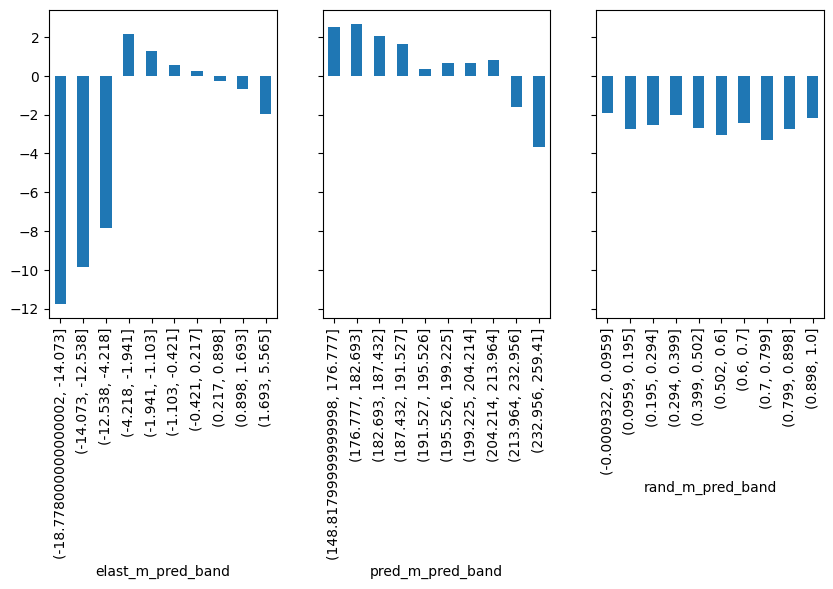

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["elast_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    elast_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)


먼저 무작위 모델인 `rand_m`을 살펴봅시다. 각 그룹은 대체로 같은 탄력성을 보입니다. 가격 탄력성이 높은 날과 낮은 날을 구분하지 못하므로 개인화가 어렵습니다. 다음으로 기계학습 예측 모델인 `m_pred`를 살펴봅시다. 이 모델은 좋습니다! 탄력성이 높은 그룹과 낮은 그룹을 구별합니다. 우리가 원했던 모델입니다.

마지막으로 선형 회귀로 얻은 인과 모델 `elast_m`은 조금 이상해 보입니다. 탄력성이 매우 낮은 그룹을 식별하는데 값이 작다면 해당 그룹은 실제로 가격 민감도가 높습니다. (가격이 오르면 매출이 크게 떨어질 것입니다) 따라서 가격 민감도가 높은 날을 감지하는 데 매우 유용합니다. 민감도가 높은 날에는 가격을 올리지 않게 주의할 것입니다. `elast_m`은 민감도가 낮은 일부 영역을 식별하므로 높은 탄력성과 낮은 탄력성을 성공적으로 구별할 수 있습니다. 하지만 예측 모델만큼 순서가 정확하지는 않습니다.

모델을 어떻게 평가해야 할까요? 어떤 모델이 더 유용한가요? `elast_m`(인과 모델)인가요 `m_pred`(예측 모델)인가요? 예측 모델은 더 나은 순서를 가지며 인과 모델은 극단 값을 잘 식별합니다. 그룹별 탄력성은 어떤 모델이 나은지는 정확하게 말해주지 않으므로 더 정교한 방법이 필요하겠습니다.

## Cumulative Elasticity Curve

`binary treatment` 예시를 다시 살펴보겠습니다. 그룹별로 `treatment`에 대한 탄력성을 얻고 민감도에 따라 그룹 순서를 재배치합니다. 즉, 가장 민감한 그룹을 앞에, 덜 민감한 그룹을 마지막에 둡니다. 위 그림에서 `Model-1`과 `Model-3`은 이미 정렬되어 있지만, `Model-2`는 그룹의 순서를 뒤집어야 합니다.

그룹을 정렬하고 나면 `Cumulative Elasticity Curve`(누적 탄력 곡선)라고 정의한 값을 계산할 준비가 됩니다. 구체적인 계산 방법은 가장 먼저 첫 번째 그룹(탄력성이 큰 그룹)의 탄력성을 계산하고, 두번째로는 첫번째와 두번째 그룹을 합한 그룹의 탄력성을 계산합니다. 모든 그룹을 포함할 때까지 이런 방식으로 탄력성을 계산합니다. 결국, 마지막 그룹에서는 전체 데이터에 대한 탄력성을 계산하게 됩니다. 아래 그림이 Cumulative Elasticity 계산 결과를 시각적으로 표현한 예시입니다.

![img](./data/img/evaluate-causal-models/cumm_elast.png)

누적 탄력성의 첫 번째 `bin`(구간)은 3개의 모델이 각기 treatment에 가장 민감하게 반응할 것이라고 예측한 그룹의 `ATE`와 같습니다. 또한, 3개의 모델 모두 누적 탄력성은 같은 지점으로 수렴되는 것을 확인할 수 있는데, 바로 전체 Dataset을 이용하여 구한 `ATE`입니다.

누적 탄력성은 수학적으로 `k` 번째 데이터까지 추정된 탄력성으로 정의됩니다.

$$
\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}
$$

누적 탄력 곡선을 얻기 위해서는 위 수식을 반복적으로 실행해 아래와 같은 수열을 만듭니다.

$$
(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)
$$

이 수열은 모델의 평가 측면에서 매우 흥미롭습니다. 왜냐하면 (이 수열에 근거하여) 어떠한 모델이 더 선호되는지를 다음과 같이 말할 수 있기 때문입니다.

첫째, 임의의 모델은 아래와 같은 정도로 더 좋다고 말할 수 있습니다.

$\hat{y}'(t)_k > \hat{y}'(t)_{k+a}$
  ($a>0$이고, 모든 $k$에서 성립)
즉, 모델이 탄력성을 잘 정렬한다면 상위 $k$ 개의 표본에서 관찰된 탄력성은 상위 $k+a$개의 표본에서 관찰된 탄력성보다 높습니다. 간단히 말하면 상위 `unit`의 탄력성은 하위 `unit`의 탄력성보다 높습니다.


둘째, 임의의 모델은 아래 식으로 표현되는 '차이'를 크게 할수록 더 좋습니다.
 $\hat{y}'(t)_k - \hat{y}'(t)_{k+a}$ ($a>0$이고, 모든 $k$에서 성립) 
단순하게 말하면, 상위 $k$개 `unit`의 탄력성이 하위 `unit`의 탄력성보다 높은 것만을 원하는게 아니라, 가능한 한 그 차이가 커지길 원한다는 생각이 깔려있습니다 

누적 탄력 곡선을 코드로 구현해보겠습니다.

In [10]:
def cumulative_elast_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]

    # cumulative computes the elasticity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([elast(ordered_df.head(rows), y, t) for rows in n_rows])

`cumulative_elast_curve` 함수를 설명하자면, 정렬된 탄력성을 `prediction`으로 받습니다. 첫 번째 그룹은 `min_periods`만큼 지정되어 다른 그룹과 크기가 다를 수 있습니다. 표본 크기가 작으면 곡선의 시작 부분에서 탄력성이 부정확해져 `min_periods`가 필요합니다. 따라서 첫 번째 그룹은 충분히 크게 잡습니다. `step`은 뒤따른 그룹의 크기를 지정합니다.

`cumulative_elast_curve`를 사용해 모델별로 누적 탄력 곡성을 그릴 수 있습니다.

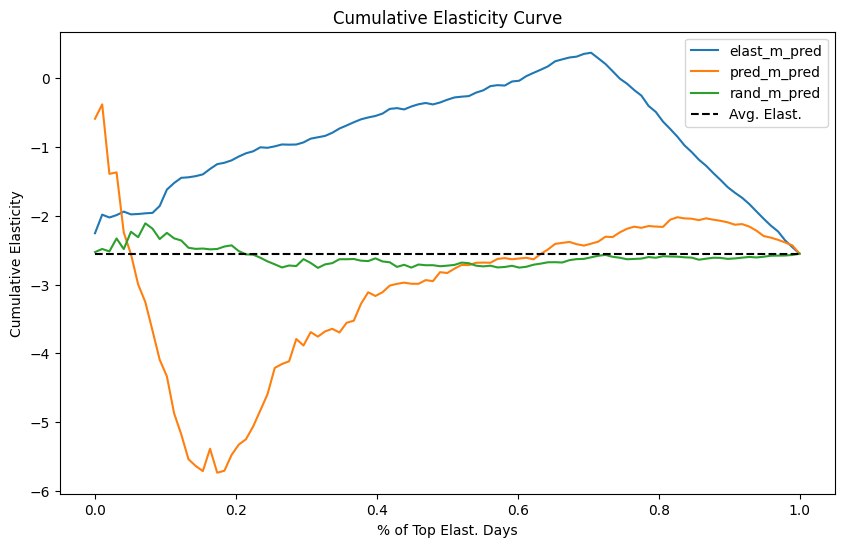

In [11]:
plt.figure(figsize=(10,6))

for m in ["elast_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_elast = cumulative_elast_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_elast)))
    plt.plot(x/x.max(), cumu_elast, label=m)

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity Curve")
plt.legend();

누적 탄력 곡선을 해석하기는 조금 어렵습니다. 제가 이해하는 방법은 다음과 같습니다. `binary treatment`를 생각하면 이해하기가 쉽습니다. X축은 처리 중인 표본 수를 나타냅니다. 총 데이터 크기로 정규화됩니다. $0.4$는 전체 데이터 중 $40$% 를 처리하고 있음을 의미합니다. Y축은 탄력성입니다. 만약 $40$%에서 값이 $-1$이라면 상위 $40$% 데이터의 탄력성은 $-1$이라는 것을 의미합니다. 이상적으로는 $X=0$일 때 가장 높은 탄력성을 가지며 $X=1$에 가까워질수록 평균 탄력성에 가까워져야 합니다.

어떠한 모델도 이상적인 누적 탄력 곡선과 가깝지 않습니다. 무작위 모델인 `rand_m`은 평균 탄력성을 중심으로 진동하며 크게 벗어나지 않습니다. 즉, 평균과 다른 그룹을 찾을 수 없습니다. 기계학습 예측 모델인 `pred_m`은 곡선이 평균 탄력성보다 낮게 시작되어 역순으로 정렬하는 것처럼 보입니다. 또한, 약 $50$% 지점에서 평균 탄력성으로 빠르게 수렴합니다. 인과 모델인 `elast_m`은 흥미로워 보입니다. 처음에는 누적 탄력성이 평균에서 벗어나 증가하는 이상한 경향을 보입니다. 하지만 $75$% 지점에서 값이 $0$인 (꽤 괜찮은 값을 유지하는) 탄력성을 보입니다. `elast_m`은 매우 낮은 가격 탄력성(높은 가격 민감도)을 가지는 날짜를 식별하기 때문에 이러한 현상이 생길 수 있습니다. $75$%에 해당하는 날짜에 대해서는 낮은 가격 민감도를 유지하면서 가격을 올릴 수 있습니다.

모형 평가 측면에서 누적 탄력 곡선은 그룹별 탄력성과 같은 단순한 아이디어보다 훨씬 우수합니다. 모델에 대한 선호도를 표현할 수 있기 때문입니다. 그래도 이해하기 어려운 곡선이므로 좀 더 개선해 보겠습니다.

## Cumulative Gain Curve

다음은 누적 탄력성에 대해 단순하지만 강력한 개선 방법을 알아보겠습니다. 방법은 누적 탄력성에 비례 표본 크기를 곱하는 것입니다. 예를 들어 누적 탄력성이 $40$%에서 $-0.5$라면, $0.4 \times -0.5 = -0.2$가 됩니다. 그리고 무작위 모델로 생성된 이론적인 곡선과 비교합니다. 이론적인 곡선은 $0$부터 `ATE`를 잇는 직선입니다. 이렇게 생각해 봅시다. 무작위 모델은 무작위 그룹을 만들기 때문에 모든 그룹에서 탄력성은 `ATE`와 같습니다. $X=(0, 1)$ 범위에서 `ATE`에 $X$를 곱하고 나면 $0$과 $ATE$를 잇는 직선이 됩니다.

![img](./data/img/evaluate-causal-models/cumm_gain.png)

이론적인 곡선을 기준으로 모델을 평가할 수 있습니다. 모든 모델의 곡선은 같은 점에서 시작해 같은 점에서 끝납니다. 하지만 모델이 탄력성을 잘 정렬할수록 곡선은 직선에서 멀어집니다. 예를 들어 위 그림에서 `Model-2`는 중간에서 직선과 더 멀어지므로 `Model-1`보다 좋습니다. `ROC`에 익숙한 분은 `Cumulative Gain`(누적 이득)을 인과 모델의 `ROC`로 생각할 수 있습니다.

수학적으로는 아래와 같습니다.

$$
\widehat{F(t)}_k = \hat{\beta_1}_k * \frac{k}{N} =\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2} * \frac{k}{N}
$$


비례 표본 크기로 정규화하는 부분만 추가하면 코드로 구현할 수 있습니다.

In [12]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

`elast_m`, `pred_m`, `rand_m`에 대해 아래와 같은 곡선을 얻을 수 있습니다.

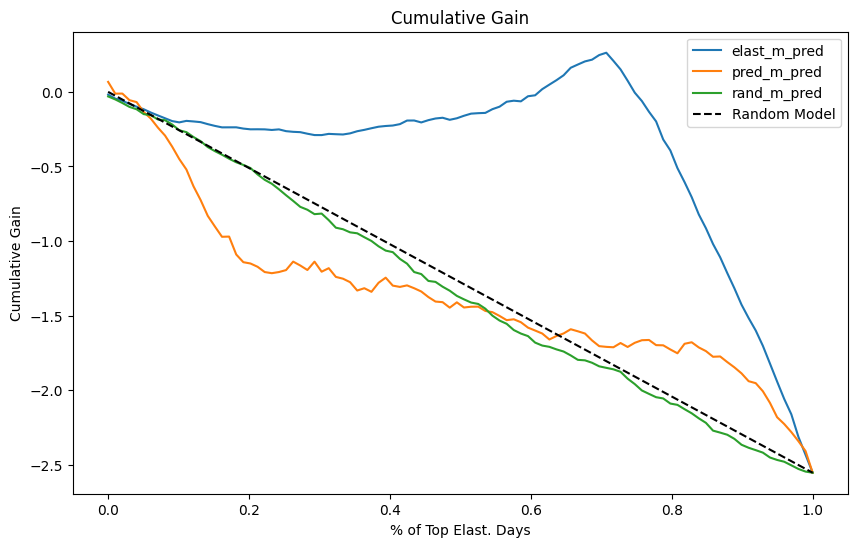

In [13]:
plt.figure(figsize=(10,6))

for m in ["elast_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

이제 인과 모델인 `elast_m`이 가장 좋다는 사실이 분명합니다. `pred_m`이나 `rand_m`보다 이론 곡선에서 더 멀기 때문입니다. 실제 무작위 모델 `rand_m`의 결과가 이론적인 곡선과 얼마나 가까운지 눈여겨봅시다. 두 곡선의 차이는 무작위 잡음입니다.

지금까지 인과 모델을 평가하는 몇 가지 멋진 아이디어를 살펴보았습니다. 이것만으로도 엄청납니다. 비교할 `ground truth`(정답)는 없었지만, 모델이 탄력성을 얼마나 잘 정렬하는지 평가할 수 있었습니다. 마지막으로 하나 남았습니다. 측정값에 대한 신뢰 구간입니다. 야만인이 될 순 없겠죠?

<figure>
    <img src="data/img/evaluate-causal-models/uncivilised.png">
    <figcaption>신뢰 구간이 없는 선형 회귀 계수를 볼 때: 미개하군!</figcaption>
</figure>


## Taking Variance Into Account

탄력 곡선을 다룰 때 분산을 고려해야 합니다. 특히 선형 회귀 이론을 사용하면 신뢰 구간을 추가하기는 꽤 쉽습니다.

먼저 선형 회귀 매개변수에 대해 CI(신뢰구간)를 반환하는 함수를 만듭니다. 여기서는 선형 회귀 공식을 사용하지만, 원하는 어떠한 방법을 사용해도 좋습니다.

$$
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$$

In [14]:
def elast_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = elast(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

`cumulative_elast_curve` 함수를 수정하여 신뢰 구간을 얻을 수 있습니다.

In [15]:
def cumulative_elast_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `elast` by a call to `elast_ci`
    return np.array([elast_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

그러면 인과 모델 `elast_m`에 대해 95% CI를 적용한 누적 탄력 곡선을 그려봅시다.

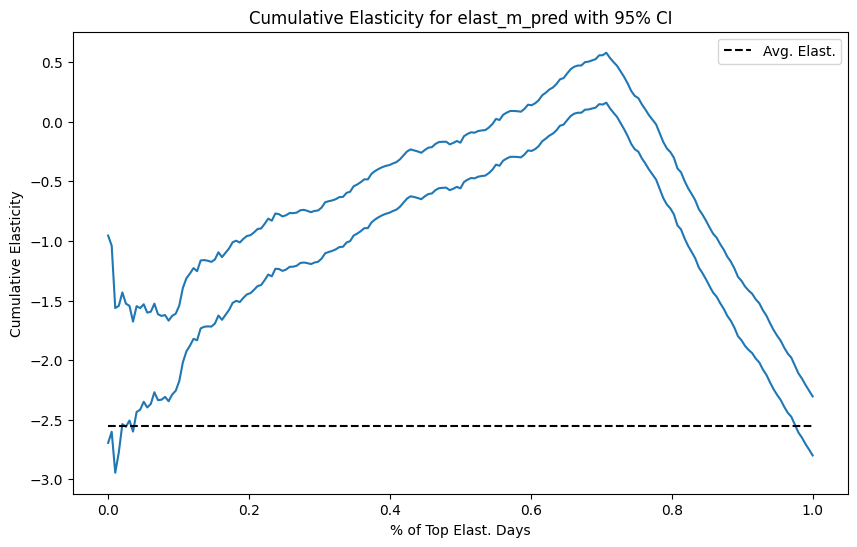

In [16]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_elast_curve_ci(prices_rnd_pred, "elast_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Elasticity")
plt.title("Cumulative Elasticity for elast_m_pred with 95% CI")
plt.legend();

데이터가 축적될수록 CI가 작아지는 것에 주목하세요. 표본 크기가 커지기 때문입니다.

누적 이득 곡선에서 CI를 얻는 것도 간단합니다. 다시 한번 함수 `elast`대신 `elast_ci`를 사용합니다.

In [17]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

아래 그림은 인과 모델 `elast_m`의 누적 이득 곡선입니다. 곡선의 시작 부분은 표본 크기가 작지만, CI도 작습니다. 정규화 계수($k/N$)가 `ATE`와 CI를 함께 줄이기 때문입니다. 누적 이득 곡선은 모델끼리 비교하는 것으로 모든 모델에서 같은 계수를 사용하는 한 문제 되지 않습니다.

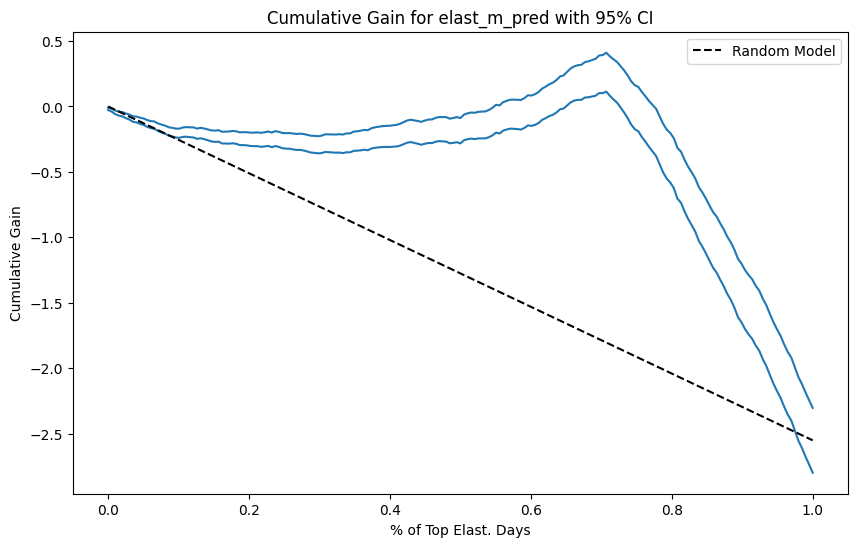

In [18]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "elast_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for elast_m_pred with 95% CI")
plt.legend();

## Key Ideas

19장에서는 탄력성을 정렬하는 방법으로 인과 모델을 평가하는 세 가지 방법을 살펴봤습니다. 탄력성에 대한 아이디어로 목적에 부합하는 모델을 평가하고 비교할 수 있었습니다. 정말 많은 일을 했네요! 탄력성을 직접 구할 수는 없었지만, 탄력성을 잘 나누는지는 확인할 수 있었습니다.

평가는 무작위 데이터에 의존했습니다. 모델은 비무작위 데이터로 훈련했지만, 모든 평가는 무작위 데이터로 했습니다. 탄력성을 확실히 추정할 방법이 필요했기 때문입니다. 무작위 데이터가 없다면 앞서 살펴본 간단한 공식은 작동하지 않을 것입니다. 단순 선형 회귀는 `confounder`(교란 변수)가 있을 때 편향을 생략하여 잘 맞지 않습니다.

무작위 데이터를 얻을 수만 있다면 모델을 잘 평가할 수 있습니다. 앞으로 비무작위 데이터 문제를 다루기 전에 마지막으로 모델 평가에 대해 한마디 하고 싶습니다.

신뢰할 수 있는 모델 평가 방법이 얼마나 중요한지 다시 한번 강조하고 싶습니다. 우리는 마침내 `cumulative gain curve`(누적 이득 곡선)로 인과 추론에 사용할 모델을 평가하는 방법을 찾았습니다. 이제 어떤 모델이 `treatment personalisation`(개인화)에 더 적합한지 결정할 수 있습니다. 이 사실은 매우 중요합니다. 인과 추론에 관한 대부분 자료는 모델 평가를 위한 좋은 방법을 알려주지 않습니다. 적합한 평가는 예측 모델만큼 인기 있는 인과 모델을 만드는 데 꼭 필요한 부분입니다. 저는 누적 이득 곡선이 예측 모델의 교차검증만큼 유용하다고 말하고 싶습니다. 이는 대담한 발언입니다. 조심스럽지만 아직은 이렇다 할 비판이 없었습니다. 더 좋은 방법이 있다면 알려주시기를 바랍니다.

## References 

The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.

I got the ideas from this chapter from a Pierre Gutierrez and Jean-Yves G'erardy's article called *Causal Inference and Uplift Modeling A review of the literature*. The authors explain the concept of a Qini curve. If you search that, you will find it's a technique used for uplift modeling, which you can think of as causal inference for when the treatment is binary. Here, I took the idea from a Qini curve and generalized it to the continuous treatment case. I think the methods presented here work for both continuous and binary cases, but then again, I've never seen them anywhere else, so keep that in mind. 

I also strongly recommend reading the article by Leo Breiman (2001) on the train-test paradigm: Statistical Modeling: The Two Cultures. It's a great resource if you want to understand what makes a statistical technique successful. 

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).